# Reinforcement learning summer school at the VU - 2022

## Workshop tutorial, day 2: 

## Deep Reinforcement Learning Agent (Part 1)

### Author: Buelent Uendes

Before we dive into deep reinforcement learning, it is a good idea to familiarize ourselves with the gym environment provided by OpenAI and start with the simple Q learning agent. In the second notebook (Deep Reinforcement Learning Agent (Part 2), we will show how we implement a deep reinforcement learning algorithm to solve the environment.

**Instructions:**

In the notebook, you will see a couple of ToDos with some instructions. Try your best to work through them and to complete the notebook. In case you run into problems, do not hesitate to ask any of the TAs for help! :) 

## Import libraries 

In [1]:
import gym
import numpy as np
import time
import matplotlib.pyplot as plt
#from IPython.display import clear_output
import time
import random

#Set the seed for reproducibility
random.seed(123)

## Open AI gym and the mountain car problem 

In the following, we will train our reinforcement learning algorithms on classical control problems provided by OpenAI gym. In particular, we will focus on the so-called mountain car problem. In this problem, the agent needs to learn how to drive a car up the right hill, given the contraint that the engine of the car is not strong enough to do right away. Starting from the bottom of the hill, the agent therefore needs to go back and forth, thereby creating enough momentum, to drive up the mountain. Compared to other classical control problems, this is a quite challenging environment.

You can find more information about the mountain car environment [here](https://www.gymlibrary.ml/environments/classic_control/mountain_car/).

## Quick recap of working with the gym environment 

## 1) Creating the environment 


Creating an environment, is fairly easy:

In [2]:
env_name = 'MountainCar-v0'
env = gym.make(env_name)

#Set the seed
env.action_space.seed(42)

[42]

## 2) Getting familiar with some of the properties of the problem 

Before starting to work on the problem, it is important to familiarize oneself with the problem at hand, i.e. investigating the observation space and the action space. 

In [3]:
print('The observation space is ', env.observation_space)
print('The action space is ', env.action_space)

The observation space is  Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
The action space is  Discrete(3)


As we can see, the observation space is continous with discrete number of actions. The agent can choose from three different actions:

- 0: Accelerate to the left
- 1: Do not accelerate
- 2: Accelerate to the right

One way to deal with continous action space is to discretize the state space into bins. This simplifies the problem and is a prerequisite for any tabular approach such as the Q learning.
    

To get a better idea of the observation space, we can check the range of the observation space.

In [4]:
low = env.observation_space.low
high =env.observation_space.high

In [5]:
low, high

(array([-1.2 , -0.07], dtype=float32), array([0.6 , 0.07], dtype=float32))

The first value of the observation space represents the x position, whereas the second one represents the velocity of the car. As we can see, the x position is in the range between $[-1.2, 0.6]$, whereas velocity lies in the range between $[-0.07, 0.07]$.

To create a new starting position, one can use the reset command as seen below:

In [6]:
env.reset()

array([-0.4452995,  0.       ], dtype=float32)

We an sample a random action from the environment via the following command:

In [7]:
env.step(env.action_space.sample())

(array([-0.44588134, -0.00058186], dtype=float32), -1.0, False, {})

## First step: Random agent

It is always a good idea to test out the environment and start to play around. For this purpose, one can create an agent that plays the game with random actions.

In [8]:
env = gym.make(env_name)
env.reset()
for _ in range(500):
    if _ % 100 == 0:
        print(_)
    action = env.step(env.action_space.sample())
    env.render()

# This will stop the environment after
env.close()

0
100
200
300
400


## In conclusion:

As a recap, the main four functions for the environment space are:
- **env.reset():** 
    Resets the environment and obtain initial starting observation
- **env.render():** 
    Visualize the environment. Important Pygame needs to be installed for this
- **env.step(action):** 
    Applies an action to it. It outputes next state, reward, done and info
- **env.close():** 
    Closes the pop-up frame of the visualized environment

## Main problem: Let's learn an agent that uses Q-learning!

As mentioned above, we will first use implement a classical approach of TD-learning, i.e. Q-learning. Q-learning is an off-policy, tabular approach to reinforcement learning. Hence, we need to discretize the state space before proceeding.

In the first step we need to digitize the observation space. Here we want to equally split the space into 19 bins using the function np.digitize. 

It is important to keep in mind that we do not want to discretize the state space too much, given the **GLIE theorem**. **GLIE theorem stands for 'Greedy in the Limit with Infinite Exploration', which means that the state action pairs Q(s,a) will converge to the optimal ones if all state-action pairs are explored infinitely many times and the policy converges to the greedy one**. For this reason, we want to have not too many states and we need to tune the epsilon rate in such a way that it converges to zero.

**ToDo:** Complete the function below that discretizes the observation space of any environment. Make use of the two functions, np.linspace and np.digitze to bin the observation space into equal bins and to allocate an observation into the corresponding bin!

Before we create a Qagent class, we will write single function that we will use for the class and make sure we understand the core pieces we need. In particular, we will need a function that discretizes the state space and a function that creates a Q table!

In [9]:
def discretizing_obs_state(env_name, state, bin_size=20):
    #State incorporates the observation state
    #State[0] is x position
    #State[1] is y position
    
    env = gym.make(env_name)
    #env.reset()
    
    #Get the low and high values of the environment space
    low = env.observation_space.low
    high =env.observation_space.high
    
    '''
    ToDo: Make use of np.linspace to create bins of equal size for the x posiion and the velocity!
    '''
    
    '''
    Solution:
    '''
    bin_size = bin_size
    bin_x = np.linspace(low[0], high[0], bin_size)
    bin_velocity = np.linspace(low[1], high[1], bin_size)
    
    #Append the two bins
    bins = [bin_x, bin_velocity]
    
    #Now we can make use of the function np.digitize and bin it
    digitized_state = []
    
    '''
    ToDo: 
    
    Write a for loop that appends the the digitized states based upon the bins you just created. 
    Make use of the np.digitize function
    
    Lastly, return the digitized states!
    
    '''
    
    '''
    Solution:
    '''
    
    for i in range(len(bins)):
        digitized_state.append(np.digitize(state[i], bins[i])-1)
    
    return digitized_state


In [10]:
def create_Q_table(bin_size, action_space):
    
    '''
    ToDo: Create a Q table that is initialized with zeros. It should have the dimension, S,S,A!
    How many effective bins do we have given the binsize?
    Return the Q table
    '''
    
    'Solution:'
    
    state_space = bin_size - 1
    return np.zeros((state_space,state_space, action_space))

## Now we can put it together and work out a Q learning agent 

In the final step, we can put everything together and create QAgent that learns how to solve the mountain car environment. An important aspect is the policy with which the agent chooses the action. A common choice is epsilon greedy, which means that with a probability fo $\epsilon$, the agent picks a random action, and with $1-\epsilon$ the agent picks the action that maximizes the corresponding Q value!

In [11]:
class QAgent():
    
    def __init__(self, env_name, discount_rate = 0.95, bin_size = 20):
        
        #create an environment
        self.env_name = env_name
        self.env = gym.make(env_name)
        
        #Set the discount rate
        self.discount_rate = discount_rate
        
        #The algorithm has then 3 different actions
        #0: Accelerate to the left
        #1: Don't accelerate
        #2: Accelerate to the right
        self.action_space = range(env.action_space.n)
        
        #Set the bin size
        self.bin_size = bin_size
        
        #State incorporates the observation state
        #State[0] is x position
        #State[1] is y position
    
        #Get the low and high values of the environment space
        self.low = self.env.observation_space.low
        self.high = self.env.observation_space.high
    
        #You could play around with the bin size!
        bin_x = np.linspace(self.low[0], self.high[0], self.bin_size)
        bin_velocity = np.linspace(self.low[1], self.high[1], self.bin_size)
    
        #Append the two bins
        self.bins = [bin_x, bin_velocity]
    
    def discretize_state(self, state):
        #Now we can make use of the function np.digitize and bin it
        self.state = state
        
        #Create an empty state
        digitized_state = []
    
        for i in range(len(self.bins)):
            digitized_state.append(np.digitize(self.state[i], self.bins[i])-1)
        
        #Returns the discretized state from an observation
        return digitized_state
    
    def create_Q_table(self):
        self.state_space = self.bin_size - 1
        #Initialize all values in the Q-table to zero
        self.Qtable = np.zeros((self.state_space, self.state_space, self.env.action_space.n))

    def train(self, simulations, learning_rate, epsilon = 1, adapting_learning_rate = False):
        #Initialize variables that keep track of the rewards
        
        self.rewards = []
        self.average_rewards = []
        
        #Call the Q table function to create a randomly initialized Q table
        self.create_Q_table()
        
        #Set epsilon rate and learning rate
        self.epsilon = epsilon
        self.learning_rate = learning_rate
        
        #Set minimum epsilon, so here we want a minimum exploration rate of 0.05
        self.epsilon_minimum = 0.05
        
        #If we choose adaptive learning rate, we start with a value of 1 and decay it over time!
        if adapting_learning_rate:
            self.learning_rate = 1
        
        for i in range(simulations):
            
            if i % 5000 == 0:
                print(f'Please wait, the algorithm is learning! The current simulation is {i}')
            #Initialize the state
            state = self.env.reset()
        
            #Set a variable that flags if an episode has terminated
            done = False
        
            #Discretize the state space
            
            state = self.discretize_state(state)
            
            #Set the rewards to 0
            total_rewards = 0
            
            #Loop until an episode has terminated
            while not done:
                
                #Pick an action based on epsilon greedy
                
                '''
                ToDo: Write a if-else statement that decides based on epsilon greedy which action to take!
                Tip: Make use of np.random.uniform() and the self.epsilon to make a decision!
                '''
                
                '''
                Solution:
                '''
                #Pick random action
                if np.random.uniform(0,1) > 1-self.epsilon:
                    #This picks a random action from 0,1,2
                    action = np.random.choice(self.action_space)
                    
                #Pick a greedy action
                else:
                    action = np.argmax(self.Qtable[state[0],state[1],:])
                    
                #Now sample the next_state, reward, done and info from the environment
                
                next_state, reward, done, info = self.env.step(action)
                
                #Now discretize the next_state
                next_state = self.discretize_state(next_state)
                
                #Adjust Q-values
                
                '''
                ToDo: Write the Q_target function that calculates the reward + discount rate * max Q value
                
                '''
                
                '''
                Solution:
                '''
                #Target value 
                Q_target = (reward + self.discount_rate*np.max(self.Qtable[next_state[0], next_state[1]]))
                
                #Calculate the Temporal difference error (delta)
                delta = self.learning_rate * (Q_target - self.Qtable[state[0], state[1], action])
                
                #Update the Q-value
                self.Qtable[state[0], state[1], action] = self.Qtable[state[0], state[1], action] + delta
                
                #Update the reward and the hyperparameters
                total_rewards += reward
                state = next_state
                
            #Decay epsilon, here we decay both the epsilon and learning rate with the number of simulations
            delta = (self.epsilon - self.epsilon_minimum)/(i+1)
            self.epsilon -= delta
            
            if adapting_learning_rate:
                self.learning_rate = self.learning_rate/np.sqrt(i)
            self.rewards.append(total_rewards)
            
            #Calculate the average score over 100 episodes
            if i % 100 == 0:
                self.average_rewards.append(np.mean(self.rewards))
                
                #Initialize a new reward list, as otherwise the average values would reflect all rewards!
                self.rewards = []
        
        print('The simulation is done!')
        
    def visualize_rewards(self):
        plt.plot(100*(np.arange(len(self.average_rewards))+1), self.average_rewards)
        plt.title('Average reward over the past 100 simulations')
        plt.xlabel('Number of simulations')
        plt.ylabel('Average reward')
    
    def play_game(self):
        #Get the optimized strategy:
        done = False
        #Start the game
        state = self.env.reset()
        while not done:
            state = self.discretize_state(state)
            #Pick the best acction from the saved Qtable
            action = np.argmax(self.Qtable[state[0],state[1],:])
            next_state, reward, done, info = self.env.step(action)
            state = next_state
            self.env.render()
            #Pause to make it easier to watch
            time.sleep(0.05)
        #Close the pop-up window
        self.env.close()

## Let's run this simulation let's say 15,000 times 

In [12]:
'''
Initialize the Qagent and and let it train over 15,000 episodes with a learning rate of your choice! 
'''

'''
Solution! Here we do it with 15,000 steps, bin size 20 and a learning rate of 0.1
'''
Qagent = QAgent(env_name, bin_size = 20)
Qagent.train(15000, learning_rate = 0.1)

Please wait, the algorithm is learning! The current simulation is 0
Please wait, the algorithm is learning! The current simulation is 5000
Please wait, the algorithm is learning! The current simulation is 10000
The simulation is done!


## Now we can plot the results 

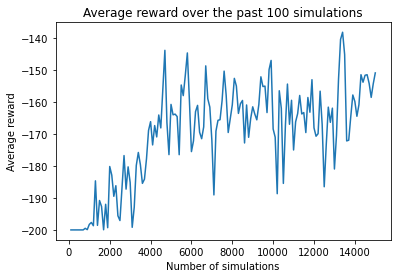

In [13]:
Qagent.visualize_rewards()

## Lastly, and finally we want to see if our QAgent learned the problem 

In [16]:
Qagent.play_game()

**Done! Did your agent managed to climb up the hill? ;)**

## Further extensions 

The code above involves the standard tabular Q learning approach. Yet, one can extend this framework, by for example, 
make a warm start that, i.e. set the starting position different from the bottom of the hill, to help the agent explore the state space better. Yet, one can consider this as a form of cheating. 

In the second notebook, we will see how we can extend the framework by approximating the Q function with a neural network, i.e. by introducing deep reinforcement learning!
